<a href="https://colab.research.google.com/github/alessioborgi/RL_Project/blob/main/X_GNN_MUTAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# X-GNN: Model-Explanations of GNNs using RL

### *Alessio Borgi*
### *Francesco Danese*

### 0: INSTALLING & IMPORTING LIBRARIES

In [208]:
!pip install torch_geometric networkx matplotlib

In [209]:
import os
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import networkx as nx
from torch.nn import Linear
import plotly.express as px
import matplotlib.pyplot as plt
import torch.nn.functional as F
import plotly.graph_objects as go
from torch_geometric.nn import MessagePassing
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import TUDataset
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.utils import to_networkx, to_dense_adj
from torch_geometric.utils import add_self_loops, remove_self_loops, degree

In [210]:
'''# Ensures that dataset splitting, model initialization, and training are deterministic.
def set_seed(seed):
    torch.manual_seed(seed)  # Fix seed for PyTorch (CPU).
    torch.cuda.manual_seed(seed)  # Fix seed for PyTorch (GPU).
    torch.cuda.manual_seed_all(seed)  # Fix seed for all GPUs.
    np.random.seed(seed)  # Fix seed for NumPy.
    random.seed(seed)  # Fix seed for Python's random module.
    torch.backends.cudnn.deterministic = True  # Ensure deterministic GPU behavior.
    torch.backends.cudnn.benchmark = False  # Disable cuDNN auto-tuning to enforce determinism.

set_seed(42)  # Set seed to ensure reproducibility across runs.
'''

"# Ensures that dataset splitting, model initialization, and training are deterministic.\ndef set_seed(seed):\n    torch.manual_seed(seed)  # Fix seed for PyTorch (CPU).\n    torch.cuda.manual_seed(seed)  # Fix seed for PyTorch (GPU).\n    torch.cuda.manual_seed_all(seed)  # Fix seed for all GPUs.\n    np.random.seed(seed)  # Fix seed for NumPy.\n    random.seed(seed)  # Fix seed for Python's random module.\n    torch.backends.cudnn.deterministic = True  # Ensure deterministic GPU behavior.\n    torch.backends.cudnn.benchmark = False  # Disable cuDNN auto-tuning to enforce determinism.\n\nset_seed(42)  # Set seed to ensure reproducibility across runs.\n"

### 1: DATASET EXPLORATION

In [211]:
# Load the MUTAG Dataset.
dataset = TUDataset(root='data/TUDataset', name='MUTAG')

In [212]:
import random
import pandas as pd
from torch_geometric.datasets import TUDataset

# Load the MUTAG Dataset.
dataset = TUDataset(root='data/TUDataset', name='MUTAG')

# Initialize lists to collect dataset-wide statistics.
num_nodes = []
num_edges = []
labels = []

dataset_indices = list(range(len(dataset)))

# Gather data about all graphs.
for data in dataset:
    num_nodes.append(data.num_nodes)
    num_edges.append(data.num_edges)
    labels.append(data.y.item())

# Create a summary DataFrame.
df = pd.DataFrame({
    "Graph ID": dataset_indices,
    "Num Nodes": num_nodes,
    "Num Edges": num_edges,
    "Label": labels
})

# Dataset Statistics.
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f"Number of Graphs: {len(dataset)}")
print(f"Number of Classes: {dataset.num_classes}")
print(f"Average Nodes per Graph: {sum(num_nodes)/len(num_nodes):.2f}")
print(f"Average Edges per Graph: {sum(num_edges)/len(num_edges):.2f}")
print("Class Distribution:")
print(df['Label'].value_counts())

# Separate the indices for each class.
class_0_indices = df[df['Label'] == 0]['Graph ID'].tolist()
class_1_indices = df[df['Label'] == 1]['Graph ID'].tolist()

# Downsample class 1 to match class 0.
random.seed(42)  # For reproducibility
balanced_class_1_indices = random.sample(class_1_indices, len(class_0_indices))

# Combine the downsampled class 1 indices with class 0 indices.
balanced_indices = class_0_indices + balanced_class_1_indices

# Update the dataset in place with the balanced indices.
dataset = [dataset[i] for i in balanced_indices]

# Update the DataFrame with the new dataset statistics.
updated_num_nodes = [dataset[i].num_nodes for i in range(len(dataset))]
updated_num_edges = [dataset[i].num_edges for i in range(len(dataset))]
updated_labels = [dataset[i].y.item() for i in range(len(dataset))]

# Create the updated DataFrame.
df = pd.DataFrame({
    "Graph ID": range(len(dataset)),
    "Num Nodes": updated_num_nodes,
    "Num Edges": updated_num_edges,
    "Label": updated_labels
})

# Updated dataset statistics.
print("\nUpdated Dataset Statistics:")
print('============================')
print(f"Number of Graphs: {len(dataset)}")
print("Class Distribution:")
print(df['Label'].value_counts())



Dataset: MUTAG(188):
Number of Graphs: 188
Number of Classes: 2
Average Nodes per Graph: 17.93
Average Edges per Graph: 39.59
Class Distribution:
Label
1    125
0     63
Name: count, dtype: int64

Updated Dataset Statistics:
Number of Graphs: 126
Class Distribution:
Label
0    63
1    63
Name: count, dtype: int64


In [213]:
# Plot class distribution using Plotly.
class_counts = df['Label'].value_counts().reset_index()
class_counts.columns = ['Label', 'Count']

fig = px.bar(
    class_counts,
    x='Label', y='Count',
    labels={"Label": "Class Label", "Count": "Count"},
    title="Class Distribution in MUTAG Dataset"
)
fig.show()


In [214]:
# Take the first graph of the Dataset.
single_graph = dataset[0]
print()
print(single_graph)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {single_graph.num_nodes}')
print(f'Number of edges: {single_graph.num_edges}')
print(f'Average node degree: {single_graph.num_edges / single_graph.num_nodes:.2f}')
print(f'Has isolated nodes: {single_graph.has_isolated_nodes()}')
print(f'Has self-loops: {single_graph.has_self_loops()}')
print(f'Is undirected: {single_graph.is_undirected()}')


Data(edge_index=[2, 28], x=[13, 7], edge_attr=[28, 4], y=[1])
Number of nodes: 13
Number of edges: 28
Average node degree: 2.15
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [215]:
import torch
import plotly.graph_objs as go
import networkx as nx
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import numpy as np

# Assuming you already have the graph data loaded as `single_graph`
# Convert the first graph in the dataset to NetworkX.
G = to_networkx(single_graph, to_undirected=True)

# Extract the node feature matrix
node_features = single_graph.x  # Shape: [num_nodes, num_features]

# Convert one-hot encoded node features to atom types (indices)
node_colors = torch.argmax(node_features, dim=1).numpy()

# Define a colormap for different atom types
cmap = plt.get_cmap("tab10")  # You can choose any matplotlib colormap
unique_atom_types = np.unique(node_colors)
colors = {atom_type: cmap(i / len(unique_atom_types)) for i, atom_type in enumerate(unique_atom_types)}

# Generate 2D layout
pos_2d = nx.spring_layout(G, seed=42)

# Prepare edge trace for 2D visualization
edge_x_2d = []
edge_y_2d = []
for edge in G.edges():
    x0, y0 = pos_2d[edge[0]]
    x1, y1 = pos_2d[edge[1]]
    edge_x_2d.extend([x0, x1, None])
    edge_y_2d.extend([y0, y1, None])

edge_trace_2d = go.Scatter(
    x=edge_x_2d, y=edge_y_2d,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines'
)

# Prepare node trace for 2D visualization
node_x_2d = []
node_y_2d = []
node_labels = []
node_colors_plotly = []

for node in G.nodes():
    x, y = pos_2d[node]
    node_x_2d.append(x)
    node_y_2d.append(y)
    atom_type_list = ['C', 'N', 'O', 'F', 'I', 'Cl', 'Br']
    atom_type = atom_type_list[node_colors[node]]
    node_labels.append(f"{atom_type}")
    rgba_color = colors[node_colors[node]]
    plotly_color = f"rgba({rgba_color[0] * 255}, {rgba_color[1] * 255}, {rgba_color[2] * 255}, {rgba_color[3]})"
    node_colors_plotly.append(plotly_color)

node_trace_2d = go.Scatter(
    x=node_x_2d, y=node_y_2d,
    mode='markers+text',
    hoverinfo='text',
    marker=dict(
        size=10,
        color=node_colors_plotly,
    ),
    text=node_labels,
    textposition="top center"
)

# 2D Visualization
fig_2d = go.Figure(data=[edge_trace_2d, node_trace_2d],
                   layout=go.Layout(
                       title="2D Visualization of Graph 0",
                       showlegend=False,
                       hovermode='closest',
                       margin=dict(b=0, l=0, r=0, t=40),
                       xaxis=dict(showgrid=False, zeroline=False),
                       yaxis=dict(showgrid=False, zeroline=False)
                   ))
fig_2d.show()

# Analyze graph properties
print(f"Number of nodes: {single_graph.num_nodes}")
print(f"Number of edges: {single_graph.num_edges}")
print(f"Is graph directed? {single_graph.is_directed()}")
print(f"Graph label: {single_graph.y}")


Number of nodes: 13
Number of edges: 28
Is graph directed? False
Graph label: tensor([0])


In [216]:
import torch
import plotly.graph_objs as go
import networkx as nx
from torch_geometric.utils import to_networkx
import numpy as np
import matplotlib.pyplot as plt

single_graph = dataset[4]
# Assuming you already have the graph data loaded as `single_graph`
# Convert the first graph in the dataset to NetworkX.
G = to_networkx(single_graph, to_undirected=True)

# Extract the node feature matrix
node_features = single_graph.x  # Shape: [num_nodes, num_features]

# Convert one-hot encoded node features to atom types (indices)
node_colors = torch.argmax(node_features, dim=1).numpy()

# Define atom labels and fixed colormap
atom_labels = ['C', 'N', 'O', 'F', 'I', 'Cl', 'Br']
fixed_colors = {
    'C': 'rgba(0, 255, 0, 1)',  # Green
    'N': 'rgba(255, 0, 0, 1)',  # Red
    'O': 'rgba(0, 0, 255, 1)',  # Blue
    'F': 'rgba(255, 255, 0, 1)',  # Yellow
    'I': 'rgba(128, 0, 128, 1)',  # Purple
    'Cl': 'rgba(255, 165, 0, 1)',  # Orange
    'Br': 'rgba(75, 0, 130, 1)'   # Indigo
}

# Generate 3D layout
pos_3d = nx.spring_layout(G, dim=3, seed=42)

# Extract node labels based on atom types
node_labels = []
node_colors_plotly = []
for node in G.nodes():
    atom_type = atom_labels[node_colors[node]]
    node_labels.append(atom_type)
    plotly_color = fixed_colors[atom_type]
    node_colors_plotly.append(plotly_color)

# Prepare edge trace for 3D visualization
edge_x_3d = []
edge_y_3d = []
edge_z_3d = []
for edge in G.edges():
    x0, y0, z0 = pos_3d[edge[0]]
    x1, y1, z1 = pos_3d[edge[1]]
    edge_x_3d.extend([x0, x1, None])
    edge_y_3d.extend([y0, y1, None])
    edge_z_3d.extend([z0, z1, None])

edge_trace_3d = go.Scatter3d(
    x=edge_x_3d, y=edge_y_3d, z=edge_z_3d,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines'
)

# Prepare node trace for 3D visualization
node_x_3d = []
node_y_3d = []
node_z_3d = []
for node in G.nodes():
    x, y, z = pos_3d[node]
    node_x_3d.append(x)
    node_y_3d.append(y)
    node_z_3d.append(z)

node_trace_3d = go.Scatter3d(
    x=node_x_3d, y=node_y_3d, z=node_z_3d,
    mode='markers+text',
    hoverinfo='text',
    marker=dict(
        size=10,
        color=node_colors_plotly,
    ),
    text=node_labels,
    textposition="top center"
)

# 3D Visualization
fig_3d = go.Figure(data=[edge_trace_3d, node_trace_3d],
                   layout=go.Layout(
                       title="3D Visualization of Graph 0",
                       showlegend=False,
                       margin=dict(b=0, l=0, r=0, t=40),
                       scene=dict(
                           xaxis=dict(showticklabels=False),
                           yaxis=dict(showticklabels=False),
                           zaxis=dict(showticklabels=False)
                       )
                   ))
fig_3d.show()

# Analyze graph properties
print(f"Number of nodes: {single_graph.num_nodes}")
print(f"Number of edges: {single_graph.num_edges}")
print(f"Is graph directed? {single_graph.is_directed()}")
print(f"Graph label: {single_graph.y}")


Number of nodes: 12
Number of edges: 26
Is graph directed? False
Graph label: tensor([0])


In [217]:
i = 0
for d in dataset:
  if d.x[:, 4].sum().item() > 0:
    print(i)
  i+=1

72


### GNN MODEL

In [218]:
#@title Model to Explain (GCN)
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter


class GraphConvolution(nn.Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    paper: Semi-Supervised Classification with Graph Convolutional Networks
    """
    # The parameters of the model include weight and bias
    def __init__(self, in_features, out_features):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))  # Weight matrix for the GCN layer
        self.bias = Parameter(torch.FloatTensor(out_features))  # Bias term for the GCN layer
        self.reset_parameters()  # Initialize parameters

    # Weight initialization
    def reset_parameters(self):
        # Initialize weights and biases using uniform distribution based on the size of the output features
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        self.bias.data.uniform_(-stdv, stdv)

    # Representation function, similar to __str__
    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

    # Compute A~ X W(0), where A~ is the normalized adjacency matrix and X is the input feature matrix
    def forward(self, input, adj):
        # input.shape = [num_nodes, features] = X
        # adj.shape = [num_nodes, num_nodes] = A~
        # torch.mm(a, b) performs matrix multiplication of a and b, torch.mul(a, b) performs element-wise multiplication (a and b must have the same dimensions)
        support = torch.mm(input, self.weight)  # Matrix multiplication of input features with weights, shape = [max_node, out_features]
        output = torch.spmm(adj, support)  # Multiply normalized adjacency matrix with the support matrix, shape = [max_node, out_features]
        return output + self.bias  # Add bias term, shape = [max_node, out_features]


class GCN(nn.Module):
    # nfeat: number of input features, nclass: number of classes for classification, dropout: dropout rate
    def __init__(self, nfeat, nclass, dropout):
        """ As per paper """
        """ 3 layers of GCNs with output dimensions equal to 32, 48, 64 respectively and average all node features """
        """ Final classifier with 2 fully connected layers and hidden dimension set to 32 """
        """ Activation function - ReLu (Mutag) """
        super(GCN, self).__init__()

        self.dropout = dropout

        # Define three GCN layers with increasing output dimensions
        self.gc1 = GraphConvolution(nfeat, 32)  # First GCN layer (input features -> 32)
        self.gc2 = GraphConvolution(32, 48)  # Second GCN layer (32 -> 48)
        self.gc3 = GraphConvolution(48, 64)  # Third GCN layer (48 -> 64)

        # Define two fully connected (linear) layers for classification
        self.fc1 = nn.Linear(64, 32)  # First fully connected layer (64 -> 32)
        self.fc2 = nn.Linear(32, nclass)  # Second fully connected layer (32 -> nclass)

    def forward(self, x, adj):
        # x.shape = [max_node, features]
        # adj.shape = [max_node, max_node]

        # First GCN layer with ReLU activation and dropout
        x = F.relu(self.gc1(x, adj))  # x.shape = [num_nodes, 32]
        x = F.dropout(x, self.dropout, training=self.training)  # Apply dropout

        # Second GCN layer with ReLU activation and dropout
        x = F.relu(self.gc2(x, adj))  # x.shape = [num_nodes, 48]
        x = F.dropout(x, self.dropout, training=self.training)  # Apply dropout

        # Third GCN layer with ReLU activation
        x = F.relu(self.gc3(x, adj))  # x.shape = [num_nodes, 64]

        # Aggregate all node features by taking the mean of all nodes
        y = torch.mean(x, 0)  # y.shape = [64], aggregate using mean over all nodes

        # Apply fully connected layers for final classification
        y = F.relu(self.fc1(y))  # First fully connected layer with ReLU activation, y.shape = [32]
        y = F.dropout(y, self.dropout, training=self.training)  # Apply dropout
        y = F.softmax(self.fc2(y), dim=0)  # Second fully connected layer with softmax activation, y.shape = [nclass]

        return y


if __name__ == '__main__':
    # Random input features of 29 nodes, each with 7 features
    input = torch.rand(29, 7)
    # Random adjacency matrix of size 29x29
    adj = torch.rand(29, 29)

    # Initialize the GCN model with 7 input features, 2 output classes, and a dropout rate of 0.1
    model = GCN(nfeat=7,  # nfeat = 7
                nclass=2,  # nclass = 2
                dropout=0.1)

    # Forward pass through the model
    output = model(input, adj)
    print(output.size())  # Output size should be [nclass], which is [2] in this case


torch.Size([2])


In [219]:
#@title Dataset reshaping for training
import torch
import numpy as np
from torch_geometric.datasets import TUDataset
from torch_geometric.utils import to_dense_adj

def accuracy(output, labels):
    """
    Computes the accuracy, given the output of the model and the true labels.

    Args:
        output (torch.Tensor): The output of the model with shape (N, num_classes).
        labels (torch.Tensor): The true labels for each sample with shape (N,).

    Returns:
        torch.Tensor: The computed accuracy as a percentage.
    """
    # Get the predicted class by finding the index of the maximum value in each row
    preds = output.argmax(dim=1)

    # Compare the predicted labels with the true labels
    correct = (preds == labels).sum().item()

    # Calculate the accuracy as the ratio of correct predictions to the total number of samples
    accuracy = correct / len(labels)

    return torch.tensor(accuracy)

def load_dataset_and_split(train_percent=0.8):
    # Prepare the output tensors
    num_graphs = len(dataset)
    max_nodes = 29  # Given that 29 is the maximum number of nodes in a single graph
    num_features = 7

    # Initialize the lists to hold the reshaped data
    adj_list = torch.zeros((num_graphs, max_nodes, max_nodes))  # [188, 29, 29]
    features_list = torch.zeros((num_graphs, max_nodes, num_features))  # [188, 29, 7]
    graph_labels = torch.zeros(num_graphs, dtype=torch.long)  # [188]

    # Iterate over each graph in the dataset
    for i, data in enumerate(dataset):
        # Number of nodes in the current graph
        num_nodes = data.num_nodes

        # Extract the node feature matrix x and store it in features_list
        features = data.x  # Shape: [num_nodes, num_features]
        features_list[i, :num_nodes, :] = features  # Padding remaining nodes with zeros

        # Create adjacency matrix from edge index and add self-loops
        adj = to_dense_adj(data.edge_index, max_num_nodes=max_nodes)[0]  # Convert edge index to dense adjacency matrix
        adj = adj + torch.eye(max_nodes)  # Add self-loops by adding an identity matrix
        adj_list[i] = adj

        # Store the graph label
        graph_labels[i] = data.y

    # Create train-val-test split indices
    num_train = int(train_percent * num_graphs)  # 80% of the data for training
    num_val = num_graphs - num_train

    # Generate shuffled indices
    indices = torch.randperm(num_graphs)

    # Assign indices to each split
    idx_train = indices[:num_train]
    idx_val = indices[num_train:]

    # Print the shapes to confirm
    print('adj_list:', adj_list.shape)  # Should be [188, 29, 29]
    print('features_list:', features_list.shape)  # Should be [188, 29, 7]
    print('graph_labels:', graph_labels.shape)  # Should be [188]
    print('idx_train:', idx_train.shape)  # Should be [80% of 188]
    print('idx_val:', idx_val.shape)  # Should be [20% of 188]

    return adj_list, features_list, graph_labels, idx_train, idx_val

In [221]:
#@title Training the GCN
import time

import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F

model_path = 'model/gcn_first.pth'

epochs = 1000
lr = 0.001
dropout = 0.1
weight_decay = 5e-4

class EarlyStopping():
    def __init__(self, patience=10, min_loss=0.5, hit_min_before_stopping=False):
        self.patience = patience
        self.counter = 0
        self.hit_min_before_stopping = hit_min_before_stopping
        if hit_min_before_stopping:
            self.min_loss = min_loss
        self.best_loss = None
        self.early_stop = False

    def __call__(self, loss):
        if self.best_loss is None:
            self.best_loss = loss
        elif loss > self.best_loss:
            self.counter += 1
            if self.counter > self.patience:
                if self.hit_min_before_stopping == True and loss > self.min_loss:
                    print("Cannot hit min loss, will continue")
                    self.counter -= self.patience
                else:
                    self.early_stop = True
        else:
            self.best_loss = loss
            counter = 0


if __name__ == '__main__':
    # adj_list: [188, 29, 29]
    # features_list: [188, 29, 7]
    # graph_labels: [188]
    adj_list, features_list, graph_labels, idx_train, idx_val = load_dataset_and_split()

    model = GCN(nfeat=features_list[0].shape[1], # nfeat = 7
                nclass=graph_labels.max().item() + 1, # nclass = 2
                dropout=dropout)
    optimizer = optim.Adam(model.parameters(),
                           lr=lr, weight_decay=weight_decay)

    model.cuda()
    features_list = features_list.cuda()
    adj_list = adj_list.cuda()
    graph_labels = graph_labels.cuda()
    idx_train = idx_train.cuda()
    idx_val = idx_val.cuda()

    idx_train = torch.cat((idx_train, idx_val))
    idx_train = idx_train.cuda()

    early_stopping = EarlyStopping(patience=20, hit_min_before_stopping=True)
    t_total = time.time()

    for epoch in range(epochs):
        t = time.time()
        model.train()
        optimizer.zero_grad()

        # # Forward pass through entire training set
        outputs = []
        outputs = [model(features_list[i], adj_list[i]).unsqueeze(0) for i in idx_train]
        output = torch.cat(outputs, dim=0)

        loss_train = F.nll_loss(torch.log(output), graph_labels[idx_train])
        acc_train = accuracy(output, graph_labels[idx_train])
        loss_train.backward()
        optimizer.step()

        model.eval()
        # # Forward pass through entire validation set
        outputs = []
        outputs = [model(features_list[i], adj_list[i]).unsqueeze(0) for i in idx_val]
        output = torch.cat(outputs, dim=0)
        loss_val = F.nll_loss(torch.log(output), graph_labels[idx_val])
        acc_val = accuracy(output, graph_labels[idx_val])

        print('Epoch: {:04d}'.format(epoch + 1),
              'loss_train: {:.4f}'.format(loss_train.item()),
              'acc_train: {:.4f}'.format(acc_train.item()),
              'loss_val: {:.4f}'.format(loss_val.item()),
              'acc_val: {:.4f}'.format(acc_val.item()),
              'time: {:.4f}s'.format(time.time() - t))

        early_stopping(loss_val)
        if early_stopping.early_stop == True:
            break

    print("Optimization Finished!")
    print("Total time elapsed: {:.4f}s".format(time.time() - t_total))

    torch.save(model.state_dict(), model_path)

adj_list: torch.Size([126, 29, 29])
features_list: torch.Size([126, 29, 7])
graph_labels: torch.Size([126])
idx_train: torch.Size([100])
idx_val: torch.Size([26])
Epoch: 0001 loss_train: 0.7081 acc_train: 0.5000 loss_val: 0.6923 acc_val: 0.5385 time: 0.4682s
Epoch: 0002 loss_train: 0.7024 acc_train: 0.5000 loss_val: 0.6883 acc_val: 0.5385 time: 0.2935s
Epoch: 0003 loss_train: 0.6950 acc_train: 0.5000 loss_val: 0.6852 acc_val: 0.5385 time: 0.1710s
Epoch: 0004 loss_train: 0.6944 acc_train: 0.5000 loss_val: 0.6826 acc_val: 0.5385 time: 0.1732s
Epoch: 0005 loss_train: 0.6897 acc_train: 0.5000 loss_val: 0.6806 acc_val: 0.5385 time: 0.1699s
Epoch: 0006 loss_train: 0.6863 acc_train: 0.5000 loss_val: 0.6790 acc_val: 0.5385 time: 0.1840s
Epoch: 0007 loss_train: 0.6841 acc_train: 0.5000 loss_val: 0.6775 acc_val: 0.5385 time: 0.1799s
Epoch: 0008 loss_train: 0.6845 acc_train: 0.5079 loss_val: 0.6761 acc_val: 0.5385 time: 0.1784s
Epoch: 0009 loss_train: 0.6815 acc_train: 0.5079 loss_val: 0.6747 acc

In [222]:
torch.save(model.state_dict(), model_path)

### GRAPH GENERATOR

In [224]:
import random
import copy
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F


class Generator(nn.Module):
    def __init__(self, model_path: str, C: list, node_feature_dim: int ,num_class = 2, c=0, hyp1=1, hyp2=2, start=None, nfeat=7, dropout=0.1):
        """
        :param C: Candidate set of nodes (list)
        :param start: Starting node (defaults to randomized node)
        """
        super(Generator, self).__init__()
        self.MAX_NUM_NODES = 29 # for mutag
        self.nfeat = nfeat
        self.dropout = dropout
        self.c = c # c is the specific class of graph to be generated

        self.fc = nn.Linear(nfeat, 8)
        self.gc1 = GraphConvolution(8, 16)
        self.gc2 = GraphConvolution(16, 24)
        self.gc3 = GraphConvolution(24, 32)

        # MLP1
        # 2 FC layers with hidden dimension 16
        self.mlp1 = nn.Sequential(nn.Linear(32, 16), nn.Linear(16, 1))

        # MLP2
        # 2 FC layers with hidden dimension 24
        self.mlp2 = nn.Sequential(nn.Linear(64, 24), nn.Linear(24, 1))

        # Hyperparameters
        self.hyp1 = hyp1
        self.hyp2 = hyp2
        self.candidate_set = C

        # Default starting node (if any)
        if start != None:
            self.start = start
            self.random_start = False
        else:
            self.start = random.choice(np.arange(0, len(self.candidate_set)))
            self.random_start = True

        # Load GCN for calculating reward
        self.model = GCN(nfeat=node_feature_dim,
                         nclass=num_class,
                         dropout=dropout)

        self.model.load_state_dict(torch.load(model_path))
        for param in self.model.parameters():
            param.requires_grad = False

        self.model.eval()
        self.reset_graph()

    def reset_graph(self):

        """
        Reset g.G to default graph with only the start node, generate a graph containing only one node
        """
        if self.random_start == True:
            self.start = random.choice(np.arange(0, len(self.candidate_set)))

        # In the initial graph, all nodes except the first one are masked. Since the adjacency matrix's edge length is MAX_NUM_NODES + len(self.candidate_set), not only the candidate nodes are masked, but also all virtual nodes in the graph
        mask_start = torch.BoolTensor(
            [False if i == 0 else True for i in range(self.MAX_NUM_NODES + len(self.candidate_set))])

        adj = torch.zeros((self.MAX_NUM_NODES + len(self.candidate_set), self.MAX_NUM_NODES + len(self.candidate_set)),
                          dtype=torch.float32)   # Here, the shape of adj is [MAX_NUM_NODES + len(self.candidate_set), MAX_NUM_NODES + len(self.candidate_set)], which may contain empty nodes

        feat = torch.zeros((self.MAX_NUM_NODES + len(self.candidate_set), len(self.candidate_set)), dtype=torch.float32)
        # the first node in the feature matrix is the starting node -> one hot encoding to make its features
        feat[0, self.start] = 1
        # this fills the bottom part of node feature matrix "x" with the candidate nodes features (just the one hot encoding for each type of node)
        feat[np.arange(-len(self.candidate_set), 0), np.arange(0, len(self.candidate_set))] = 1
        # the remaining MAX_NUM_NODES - len(candidate_set) - 1(start node) features are empty, all zeros, since we start with a single node and the candidate set

        degrees = torch.zeros(self.MAX_NUM_NODES)

        self.G = {'adj': adj, 'feat': feat, 'degrees': degrees, 'num_nodes': 1, 'mask_start': mask_start}

    ## Calculate Gt -> Gt+1
    def forward(self, G_in):
        ## G_in is Gt
        G = copy.deepcopy(G_in)

        x = G['feat'].detach().clone() # Feature matrix of Gt
        adj = G['adj'].detach().clone() # Adjacency matrix of Gt

        ## Corresponds to X = GCNs(Gt​,C)
        x = F.relu6(self.fc(x))
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.relu6(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.relu6(self.gc2(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.relu6(self.gc3(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)

        ## pt,start=Softmax(MLPs(X))
        p_start = self.mlp1(x)
        p_start = F.log_softmax(p_start, dim=0)
        a_start_idx = torch.argmax(p_start.masked_fill(G['mask_start'].unsqueeze(1), -1e8))

        ## pt,end=Softmax(MLPs([X,x^start​))
        # broadcast
        x1, x2 = torch.broadcast_tensors(x, x[a_start_idx])
        x = torch.cat((x1, x2), 1)  # cat increases dim from 32 to 64

        # Calculate mask_end, except for the candidate set and nodes in Gt that have not been selected as starting nodes, all others are masked
        mask_end = torch.BoolTensor([True for i in range(self.MAX_NUM_NODES + len(self.candidate_set))])
        mask_end[self.MAX_NUM_NODES:] = False
        mask_end[:G['num_nodes']] = False
        mask_end[a_start_idx] = True

        p_end = self.mlp2(x)
        p_end = F.log_softmax(p_end, dim=0)
        a_end_idx = torch.argmax(p_end.masked_fill(mask_end.unsqueeze(1), -1e8))
        # Return new G
        # If a_end_idx is not masked, the node exists in the graph, no new node added
        if G['mask_start'][a_end_idx] == False:
            G['adj'][a_end_idx][a_start_idx] += 1
            G['adj'][a_start_idx][a_end_idx] += 1

            # Update degrees
            G['degrees'][a_start_idx] += 1
            G['degrees'][a_end_idx] += 1 # ???? original line: G['degrees'][G['num_nodes']] += 1
        else: # if end-node was chosen from candidate set:
            # Add node
            G['feat'][G['num_nodes']] = G['feat'][a_end_idx]
            # Add edge
            G['adj'][G['num_nodes']][a_start_idx] += 1
            G['adj'][a_start_idx][G['num_nodes']] += 1
            # Update degrees
            G['degrees'][a_start_idx] += 1
            G['degrees'][G['num_nodes']] += 1

            # Update start mask
            G_mask_start_copy = G['mask_start'].detach().clone()
            G_mask_start_copy[G['num_nodes']] = False
            G['mask_start'] = G_mask_start_copy

            G['num_nodes'] += 1

        return p_start, a_start_idx, p_end, a_end_idx, G


    ### Reward function
    def calculate_reward(self, G_t_1):
        """
        Rtr     Calculated from graph rules to encourage generated graphs to be valid
                1. Only one edge to be added between any two nodes
                2. Generated graph cannot contain more nodes than predefined maximum node number
                3. (For chemical) Degree cannot exceed valency
                If generated graph violates graph rule, Rtr = -1

        Rtf     Feedback from trained model
        """

        rtr = self.check_graph_rules(G_t_1)

        rtf = self.calculate_reward_feedback(G_t_1)
        rtf_sum = 0
        rollout = 10
        for m in range(rollout):
            p_start, a_start, p_end, a_end, G_t_1 = self.forward(G_t_1)
            rtf_sum += self.calculate_reward_feedback(G_t_1)
        rtf = rtf + self.hyp1 * (rtf_sum / rollout)

        return rtf + self.hyp2 * rtr

    def calculate_reward_feedback(self, G_t_1):
        """
        p(f(G_t_1) = c) - 1/l
        where l denotes number of possible classes for f
        """
        f = self.model(G_t_1['feat'], G_t_1['adj'])
        return f[self.c] - (1 / len(f))


    ## Graph rules
    def check_graph_rules(self, G_t_1):
        """
        For mutag, node degrees cannot exceed valency
        """
        for idx, d in enumerate(G_t_1['degrees']):
            if d != 0:
                node_id = torch.argmax(G_t_1['feat'][idx])  # Eg. [0, 1, 0, 0] -> 1 (the index)
                node = self.candidate_set[node_id]  # Eg ['C.4', 'F.2', 'Br.7'][1] = 'F.2'
                max_valency = int(node.split('.')[1])  # Eg. C.4 -> ['C', '4'] -> 4

                # If any node degree exceeds its valency, return -1
                if max_valency < d:
                    return -1

        # if there are more than 1 edge between any 2 nodes, return -1
        if torch.any(G_t_1['adj'] > 1):
            return -1

        return 0


    ## Calculate loss
    def calculate_loss(self, Rt, p_start, a_start, p_end, a_end, G_t_1):
        """
        Calculated from cross entropy loss (Lce) and reward function (Rt)
        where loss = -Rt*(Lce_start + Lce_end)
        """

        Lce_start = F.nll_loss(torch.reshape(p_start, (1, 36)), a_start.unsqueeze(0)) # nll since we have already computed log_softmax
        Lce_end = F.nll_loss(torch.reshape(p_end, (1, 36)), a_end.unsqueeze(0))

        return Rt * (Lce_start + Lce_end) # ???? original was -Rt * (Lce_start + Lce_end), with minus sign


### TRAINING GENERATOR

In [225]:
import torch.optim as optim

def train_generator(generator, num_episodes=1000, max_gen_step=10, max_nodes = 6, learning_rate=0.01, b1=0.9, b2=0.999):
    """
    Train the generator to produce graphs that maximize the target GNN's confidence for a given class.

    :param generator: An instance of the Generator class
    :param num_episodes: Number of training episodes
    :param max_gen_step: Maximum steps for generating the graph (e.g., maximum number of nodes)
    :param learning_rate: Learning rate for the optimizer
    :param b1, b2: Beta parameters for Adam optimizer
    """
    # Set up the optimizer
    optimizer = optim.Adam(generator.parameters(), lr=learning_rate, betas=(b1, b2))

    # Training loop
    for episode in range(num_episodes):
        # Reset the graph to start from a single node
        generator.reset_graph()

        R_sum = 0
        Loss_sum = 0
        count = 0

        for step in range(max_gen_step):
            G = copy.deepcopy(generator.G)
            # Forward pass: Generate the next step in the graph (Gt -> Gt+1)
            p_start, a_start, p_end, a_end, G = generator.forward(G)

            # Calculate the reward for the generated graph G_t+1
            Rt = generator.calculate_reward(G)
            R_sum += Rt
            count += 1
            # Calculate loss using the reward and generated probabilities
            loss = generator.calculate_loss(Rt, p_start, a_start, p_end, a_end, G)
            Loss_sum += loss

            # Perform backpropagation and update the generator's parameters
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Check if the number of nodes exceeds the allowed max_gen_step
            if G['num_nodes'] > max_nodes:
                generator.reset_graph()
            elif Rt > 0:
                generator.G = G

        # Logging for debugging or monitoring training progress
        if episode % 10 == 0:
            print(f"Episode {episode}/{num_episodes}, mean Loss: {loss/count}, Mean_Reward: {R_sum/count}")

    print("Training complete.")

# Example usage:
if __name__ == "__main__":
    # Initialize the Generator with the appropriate parameters
    model_path = 'model/gcn_first.pth'
    candidate_set = ['C.4', 'N.4', 'O.2', 'F.1', 'I.1', 'Cl.1', 'Br.1']
    g = Generator(model_path=model_path, C=candidate_set, node_feature_dim=7, c=0, start=0)

    # Train the generator
    train_generator(g, num_episodes=100, max_gen_step=10, learning_rate=0.01)


<ipython-input-224-ed4ad8f12f12>:53: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



Episode 0/100, mean Loss: 0.5116746425628662, Mean_Reward: -0.7763396501541138
Episode 10/100, mean Loss: 6.17477560043335, Mean_Reward: 0.3016367554664612
Episode 20/100, mean Loss: 11.65902042388916, Mean_Reward: -0.5147901177406311
Episode 30/100, mean Loss: -4.638642311096191, Mean_Reward: -0.7113651037216187
Episode 40/100, mean Loss: -29.463603973388672, Mean_Reward: -0.49372953176498413
Episode 50/100, mean Loss: 3.0181992053985596, Mean_Reward: 0.49995023012161255
Episode 60/100, mean Loss: -22.76341438293457, Mean_Reward: 0.07943999767303467
Episode 70/100, mean Loss: -15.417019844055176, Mean_Reward: 0.2847904562950134
Episode 80/100, mean Loss: 9.789546966552734, Mean_Reward: 0.6761916875839233
Episode 90/100, mean Loss: 5.602238655090332, Mean_Reward: 0.7101069688796997
Training complete.


In [226]:
#@title Draw the graph
def display_graph(G):
    G_nx = nx.from_numpy_array(np.asmatrix(G['adj'][:G['num_nodes'], :G['num_nodes']].numpy()))
    # nx.draw_networkx(G_nx)

    layout = nx.spring_layout(G_nx)
    nx.draw(G_nx, layout)

    coloring = torch.argmax(G['feat'], 1)
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    for i in range(7):
        nx.draw_networkx_nodes(G_nx, pos=layout, nodelist=[x for x in G_nx.nodes() if coloring[x] == i], node_color=colors[i])
        nx.draw_networkx_labels(G_nx, pos=layout, labels={x: candidate_set[i].split('.')[0] for x in G_nx.nodes() if coloring[x] == i})
    nx.draw_networkx_edges(G_nx, pos=layout, width=list(nx.get_edge_attributes(G_nx, 'weight').values()))
    nx.draw_networkx_edge_labels(G_nx, pos=layout, edge_labels=nx.get_edge_attributes(G_nx, "weight"))
    plt.show()

In [227]:
#@title Generate graph
# Function to generate a graph after training is complete
def generate_graph(generator, max_gen_step=10, max_nodes = 4):
    """
    Generate a graph using the trained generator.

    :param generator: An instance of the trained Generator class
    :param max_gen_step: Maximum number of steps for generating the graph.
    :return: Generated graph G
    """
    # Reset graph to start from a single node
    generator.reset_graph()
    for step in range(max_gen_step):
        G = copy.deepcopy(generator.G)
        # Generate next step in the graph (Gt -> Gt+1)
        _, _, _, _, G = generator.forward(G)
        reward = generator.calculate_reward(G)
        # Stop if the number of nodes exceeds max_gen_step
        print(reward.item())
        if G['num_nodes'] > max_nodes:
            break
        if reward > 0:
            generator.G = G

    return G

0.6674268245697021
0.6795312762260437
-1.298810362815857
0.7083084583282471
0.7256581783294678
-1.2627540826797485
-1.2792675495147705
-1.271297574043274
0.7355755567550659
-1.2578632831573486


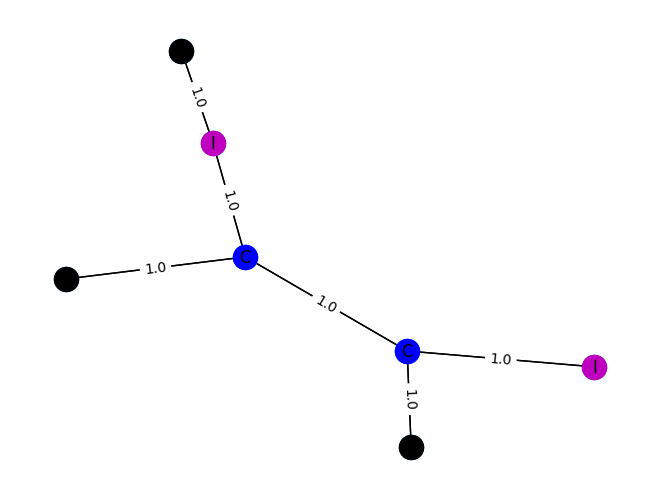

tensor([0.8669, 0.1331])

In [230]:
to_display = generate_graph(g, max_gen_step = 10, max_nodes = 6)
display_graph(to_display)
g.model(to_display['feat'], to_display['adj'])

### TEST

In [ ]:
from Load_dataset import load_split_MUTAG_data, accuracy
from Model import GCN
import time

import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F

model_path = 'model/gcn_first.pth'

if __name__ == '__main__':
    adj_list, features_list, graph_labels, idx_map, idx_train, idx_val, idx_test = load_split_MUTAG_data()
    model = GCN(nfeat=features_list[0].shape[1],  # nfeat = 7
                nclass=graph_labels.max().item() + 1,  # nclass = 2
                dropout=0.1)

    model.eval()
    outputs = []
    for i in idx_test:
        output = model(features_list[i], adj_list[i])
        output = output.unsqueeze(0)
        outputs.append(output)
    output = torch.cat(outputs, dim=0)

    loss_test = F.cross_entropy(output, graph_labels[idx_test])
    acc_test = accuracy(output, graph_labels[idx_test])
    print(loss_test)
    print(acc_test)

ModuleNotFoundError: No module named 'Load_dataset'